In [45]:
%load_ext autoreload 
%autoreload 2
import pandas as pd
import os
import matplotlib.pyplot as plt

from mimic_helper_fs import get_ids_with_icd_codes, get_ids_with_kws
from mimic_helper_fs import get_coocurring_symptoms_codes, get_coocurring_symptoms_kws

from ipv_codes import NHAS_IPV_CODES, OREGON_IPV_CODES, USED_IPV_CODES, ICD10_IPV_CODES
from ipv_codes import KW_SETS, CODE_SETS

pd.set_option('max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 80)

mimic_iv_ed_data_path = '~/physionet.org/files/mimic-iv-ed/1.0/ed/'
mimic_iv_data_path = '~/physionet.org/files/mimiciv/1.0/'
hosp_data_path = mimic_iv_data_path + 'hosp/'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Distribution of acuity

In [46]:
triage = pd.read_csv(mimic_iv_ed_data_path + 'triage.csv.gz')
admissions = pd.read_csv(mimic_iv_data_path + 'core/admissions.csv.gz')[['subject_id', 'ethnicity', 
                                                                          'language', 'marital_status', 'hospital_expire_flag']]

triage_admissions = pd.merge(triage, admissions, on='subject_id', how='inner')
triage_admissions = triage_admissions.drop_duplicates()

In [56]:
print("# of Patients in Triage: ", len(set(triage['subject_id'])))
print("# of Patients in Admissions table: ", len(set(admissions['subject_id'])))

# of Patients in Triage:  216877
# of Patients in Admissions table:  256878


In [59]:
print("# of patients in both: ", len(set(triage['subject_id']).intersection(set(admissions['subject_id']))))

# of patients in both:  129668


In [72]:
from scipy.stats import pearsonr
notna_idxs = list(triage_admissions['acuity'].notna())
acuity_scores = np.array(list(triage_admissions['acuity'][notna_idxs]))
mortality_labels = np.array(list(triage_admissions['hospital_expire_flag'][notna_idxs]))

pearsonr(acuity_scores, mortality_labels)

(-0.09226460461494956, 0.0)

In [73]:
mortality_labels

array([0, 1, 0, ..., 0, 0, 0])

(array([2779.,    0., 7840.,    0.,    0., 5652.,    0.,  142.,    0.,
           8.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

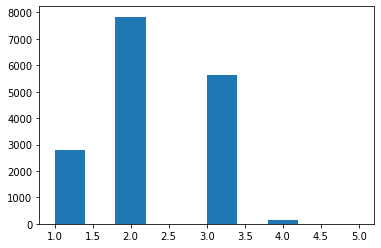

In [74]:
plt.hist(acuity_scores[mortality_labels == 1])

Text(0.5, 0, 'Acuity Score')

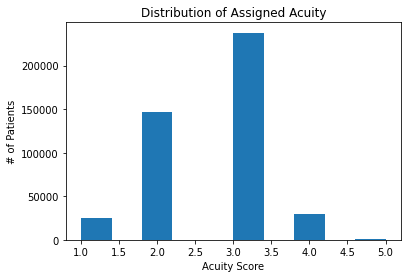

In [47]:
# Only 1175 -- .2% -- are assigned a severity score of 5!
# ~7% are assigned a score of 4 or 5
plt.hist(triage['acuity'])
plt.title("Distribution of Assigned Acuity")
plt.ylabel("# of Patients")
plt.xlabel("Acuity Score")

# Rate of mortality

In [54]:
import numpy as np
np.mean(triage_admissions['hospital_expire_flag'])

0.04162360281733272

# Benchmark analysis

In [18]:
# Still have to include chief complaint 
#  but how


62892

In [73]:
triage_subject_ids = set(triage['subject_id'])
hosp_subject_ids = set(admissions['subject_id'])

In [74]:
print("# Patients in Triage: ", len((triage_subject_ids)))
print("# Patients in Hospit:  ", len(hosp_subject_ids))
print("# Patients in Both:  ", len(triage_subject_ids.intersection(hosp_subject_ids)))

# Patients in Triage:  216877
# Patients in Hospit:   256878
# Patients in Both:   129668


In [75]:
len(set(triage_admissions['subject_id']))

129668

# Outcome analysis

In [30]:
# Train p(mortality | observable variables)
feature_names = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',]
label_name = ['hospital_expire_flag']

x = triage_admissions[feature_names]
y = triage_admissions[label_name]


# Add missingness indicator for each feature
for feature_name in feature_names:
    missingness_indicator = feature_name + "_missing"
    feature_names.append(missingness_indicator)
    missingness = x[feature_name].notna().astype(int)
    x[missingness_indicator] = missingness
x = x.fillna(0)
x = x.values
y = y.values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)
# guess this could be any f 

/home/t-dshanmugam/.conda/envs/ipv/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [33]:
# scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=500)
lr.fit(x_train, y_train[:,0])

LogisticRegression(max_iter=500)

In [42]:
from sklearn.metrics import roc_auc_score
# AUC of .64 predicting the 
roc_auc_score(y_test, lr.predict_proba(x_test)[:,1])

0.6496107959388524

In [43]:
lr.coef_

array([[ 1.24216329e-01,  1.24006467e-01,  6.90919156e-03,
        -1.24351017e+00, -2.03411851e-02, -1.09476883e+01,
        -1.34869358e-01, -2.24533396e-01, -1.71673705e-01,
        -2.34327462e-02,  7.57444366e-01,  8.74037048e-02,
         1.63759737e-01, -9.60716499e-02]])

In [44]:
feature_names

['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']

In [ ]:
temperature, heartrate, o2sat, dbp, pain